In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns


# OVERVIEW


Title:
Predicting Bitcoin Price Movement Using Twitter Sentiment and Machine Learning

Objective:
The goal of this project is to determine whether aggregated Twitter sentiment about Bitcoin can be used to forecast its price movement over the next 24 hours. Cryptocurrencies like Bitcoin are highly volatile and influenced heavily by investor sentiment, which makes traditional financial models less effective.
We go through the tweets made about the bitcoins in twitter. and predict bitcoin price based on tweet's sentiment. For positive, price will increase. if negative viceversa.

Data Sources:

1.Historical Bitcoin Price Data: Provides the ground truth for price movement (Open, Close, High, Low, Volume).   [](http://)https://www.kaggle.com/datasets/mohammednawazkagle04/bitcoins-history-data

2.Twitter Sentiment Data: Tweets mentioning Bitcoin, analyzed to compute sentiment scores (positive, negative, neutral).
[](http://)https://www.kaggle.com/datasets/mohammednawazkagle04/btc-tweets-sentiment


# LOAD DATASETS 

In [2]:
import os

print(" Bitcoin price dataset contains:")
print(os.listdir("/kaggle/input/bitcoins-history-data"))

print("\n Tweet sentiment dataset contains:")
print(os.listdir("/kaggle/input/btc-tweets-sentiment"))


 Bitcoin price dataset contains:
['btcusd_1-min_data.csv']

 Tweet sentiment dataset contains:
['BTC_Tweets_Updated.csv']


In [3]:
import pandas as pd

btc_price = pd.read_csv('/kaggle/input/bitcoins-history-data/btcusd_1-min_data.csv')
tweets = pd.read_csv('/kaggle/input/btc-tweets-sentiment/BTC_Tweets_Updated.csv')

print("BTC Price Data:", btc_price.shape)
print("Tweets Data:", tweets.shape)


BTC Price Data: (7244316, 6)
Tweets Data: (50852, 11)


In [4]:
print("BTC Price Columns:\n", btc_price.columns)
print("\nTweets Columns:\n", tweets.columns)



BTC Price Columns:
 Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

Tweets Columns:
 Index(['id', 'Date', 'Tweet', 'Screen_name', 'Source', 'Link', 'Sentiment',
       'sent_score', 'New_Sentiment_Score', 'New_Sentiment_State',
       'BERT Labels'],
      dtype='object')


In [5]:
tweets['Date'] = pd.to_datetime(tweets['Date'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')


# DATE AND TIME CONVERSION:

In [6]:
# BTC dataset
btc_price.columns = ['Timestamp','Open','High','Low','Close','Volume']

# Convert timestamp to datetime
btc_price['Date'] = pd.to_datetime(btc_price['Timestamp'], unit='s')
btc_price.drop(columns=['Timestamp'], inplace=True)

# Tweets dataset
tweets.columns = ['id','Date','Tweet','Screen_name','Source','Link','Sentiment','sent_score','New_Sentiment_Score','New_Sentiment_State','BERT_Labels']

# Convert Twitter dates to datetime
tweets['Date'] = pd.to_datetime(tweets['Date'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')
tweets['Date'] = tweets['Date'].dt.tz_localize(None)  # remove timezone




In [7]:
# Check BTC dataset
print(btc_price.head())

# Check Tweets dataset
print(tweets.head())


   Open  High   Low  Close  Volume                Date
0  4.58  4.58  4.58   4.58     0.0 2012-01-01 10:01:00
1  4.58  4.58  4.58   4.58     0.0 2012-01-01 10:02:00
2  4.58  4.58  4.58   4.58     0.0 2012-01-01 10:03:00
3  4.58  4.58  4.58   4.58     0.0 2012-01-01 10:04:00
4  4.58  4.58  4.58   4.58     0.0 2012-01-01 10:05:00
   id                Date                                              Tweet  \
0   0 2018-03-23 00:40:32  RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...   
1   1 2018-03-23 00:40:34  @lopp @_Kevin_Pham @psycho_sage @naval But @Pr...   
2   2 2018-03-23 00:40:35  RT @tippereconomy: Another use case for #block...   
3   3 2018-03-23 00:40:36                 free coins https://t.co/DiuoePJdap   
4   4 2018-03-23 00:40:36  RT @payvxofficial: WE are happy to announce th...   

      Screen_name                                        Source  \
0  myresumerocket                                            []   
1        BitMocro                                  [u'B

In [8]:
# Assuming your BTC dataset is named btc_price
btc_price.columns = ['Timestamp','Open','High','Low','Close','Volume']

# Convert epoch seconds to datetime
btc_price['Date'] = pd.to_datetime(btc_price['Timestamp'], unit='s')

# Drop old Timestamp column
btc_price.drop(columns=['Timestamp'], inplace=True)


 CREATES DAILY SUMMARY OF DATA:

In [9]:
# Parse tweet dates if not done
tweets['Date'] = pd.to_datetime(tweets['Date'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')
tweets['Date'] = tweets['Date'].dt.tz_localize(None)  # remove timezone

# Aggregate tweets per day
tweet_daily = tweets.groupby(tweets['Date'].dt.date).agg({
    'New_Sentiment_Score':'mean',          # average sentiment per day
    'Tweet':'count',                        # total tweets per day
    'BERT_Labels': lambda x: (x==1).sum()  # count positive tweets
}).rename(columns={'Tweet':'Total_Tweets','BERT_Labels':'Positive_Tweets'})


In [10]:
import pandas as pd

# Load BTC Price dataset
btc = pd.read_csv("/kaggle/input/bitcoins-history-data/btcusd_1-min_data.csv")

# Load Tweet Sentiment dataset
tweets = pd.read_csv("/kaggle/input/btc-tweets-sentiment/BTC_Tweets_Updated.csv")

print(" BTC Data Shape:", btc.shape)
print(" Tweets Data Shape:", tweets.shape)



 BTC Data Shape: (7244316, 6)
 Tweets Data Shape: (50852, 11)


# CODE TO LOAD AND USES BERT POSITIVES:

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1️ Load datasets
btc = pd.read_csv("/kaggle/input/bitcoins-history-data/btcusd_1-min_data.csv")
tweets = pd.read_csv("/kaggle/input/btc-tweets-sentiment/BTC_Tweets_Updated.csv")

#  2️ Fix BTC timestamps (assuming UNIX milliseconds; change 'ms' to 's' if needed)
btc['Timestamp'] = pd.to_datetime(btc['Timestamp'], unit='ms', errors='coerce')

# Drop invalid timestamps
btc = btc.dropna(subset=['Timestamp'])

# Aggregate BTC to daily
btc_daily = (
    btc.groupby(btc['Timestamp'].dt.date)
    .agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })
    .reset_index()
    .rename(columns={'Timestamp': 'Date'})
)

#  Process tweet dates
tweets['Date'] = pd.to_datetime(tweets['Date'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')
tweets['Date'] = tweets['Date'].dt.tz_localize(None)

# Aggregate tweets daily
tweet_daily = (
    tweets.groupby(tweets['Date'].dt.date)
    .agg({
        'New_Sentiment_Score': 'mean',
        'Tweet': 'count',
        'BERT Labels': lambda x: (x == 1).sum()
    })
    .rename(columns={'Tweet': 'Total_Tweets', 'BERT Labels': 'Positive_Tweets'})
    .reset_index()
    .rename(columns={'Date': 'Tweet_Date'})
)

#  4 Convert both dates to date-only for merging
btc_daily['Date'] = pd.to_datetime(btc_daily['Date']).dt.date
tweet_daily['Tweet_Date'] = pd.to_datetime(tweet_daily['Tweet_Date']).dt.date

#  5️ Merge BTC and tweet sentiment (left join keeps all BTC dates)
merged = pd.merge(
    btc_daily, tweet_daily,
    left_on='Date', right_on='Tweet_Date',
    how='left'
)
merged.drop(columns=['Tweet_Date'], inplace=True)

# Fill missing tweet sentiment with 0
merged[['New_Sentiment_Score', 'Total_Tweets', 'Positive_Tweets']] = merged[
    ['New_Sentiment_Score', 'Total_Tweets', 'Positive_Tweets']
].fillna(0)

#  6️ Create target variable
merged['Next_Close'] = merged['Close'].shift(-1)
merged['Price_Change'] = merged['Next_Close'] - merged['Close']
merged = merged.dropna(subset=['Close', 'Next_Close', 'Price_Change'])
merged['Target'] = (merged['Price_Change'] > 0).astype(int)

print("Merged dataset ready:", merged.shape)
print(merged.head())

#  7️ Train-test split
X = merged[['Open', 'High', 'Low', 'Close', 'Volume', 
            'New_Sentiment_Score', 'Total_Tweets', 'Positive_Tweets']]
y = merged['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

#  8️ Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)



Merged dataset ready: (5, 12)
         Date      Open      High       Low     Close        Volume  \
0  1970-01-16      4.58    259.34      3.80    179.90  3.434362e+06   
1  1970-01-17    179.90   1163.00    152.40    679.95  1.400303e+07   
2  1970-01-18    679.95  19666.00    465.28   5078.19  1.008608e+07   
3  1970-01-19   5073.93  69000.00   3850.00  41707.08  7.133262e+06   
4  1970-01-20  41752.50  73794.00  15479.00  60745.00  2.093349e+06   

   New_Sentiment_Score  Total_Tweets  Positive_Tweets  Next_Close  \
0                  0.0           0.0              0.0      679.95   
1                  0.0           0.0              0.0     5078.19   
2                  0.0           0.0              0.0    41707.08   
3                  0.0           0.0              0.0    60745.00   
4                  0.0           0.0              0.0   113110.00   

   Price_Change  Target  
0        500.05       1  
1       4398.24       1  
2      36628.89       1  
3      19037.92       1 

In [12]:
btc = pd.read_csv("/kaggle/input/bitcoins-history-data/btcusd_1-min_data.csv")


In [13]:
print(os.listdir("/kaggle/input/btc-tweets-sentiment"))


['BTC_Tweets_Updated.csv']


In [14]:
tweets = pd.read_csv("/kaggle/input/btc-tweets-sentiment/BTC_Tweets_Updated.csv")


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
bitcoin_df = pd.read_csv("/kaggle/input/bitcoins-history-data/btcusd_1-min_data.csv")
tweets_df = pd.read_csv("/kaggle/input/btc-tweets-sentiment/BTC_Tweets_Updated.csv")


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


In [18]:
# Load Bitcoin price data
bitcoin_df = pd.read_csv("/kaggle/input/bitcoins-history-data/btcusd_1-min_data.csv")

# Load Tweets sentiment data
tweets_df = pd.read_csv("/kaggle/input/btc-tweets-sentiment/BTC_Tweets_Updated.csv")

print("Bitcoin data shape:", bitcoin_df.shape)
print(" Tweets data shape:", tweets_df.shape)


Bitcoin data shape: (7244316, 6)
 Tweets data shape: (50852, 11)


CONVERTION OF DATA COLUMNS:

In [19]:
# Rename Timestamp → Date for Bitcoin data
bitcoin_df.rename(columns={'Timestamp': 'Date'}, inplace=True)

# Convert both to datetime
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'], errors='coerce')
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'], errors='coerce')

print(" Date columns converted successfully!")


/tmp/ipykernel_37/4219198975.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tweets_df['Date'] = pd.to_datetime(tweets_df['Date'], errors='coerce')


 Date columns converted successfully!


In [20]:
tweets_daily = tweets_df.groupby(tweets_df['Date'].dt.date).agg({
    'New_Sentiment_Score': 'mean'
}).reset_index()

tweets_daily.rename(columns={'Date': 'Date', 'New_Sentiment_Score': 'Avg_Sentiment'}, inplace=True)


In [21]:
# Bitcoin daily close
bitcoin_daily = bitcoin_df.groupby(bitcoin_df['Date'].dt.date).agg({'Close':'last','Volume':'sum'}).reset_index()

# Tweets daily average sentiment
tweets_daily = tweets_df.groupby(tweets_df['Date'].dt.date).agg({'New_Sentiment_Score':'mean'}).reset_index()
tweets_daily.rename(columns={'New_Sentiment_Score':'Avg_Sentiment'}, inplace=True)


In [22]:
merged_df = pd.merge(bitcoin_daily, tweets_daily, on='Date', how='inner')
merged_df.dropna(inplace=True)


In [23]:
merged_df['Next_Close'] = merged_df['Close'].shift(-1)
merged_df['Target'] = (merged_df['Next_Close'] > merged_df['Close']).astype(int)
merged_df.dropna(inplace=True)


# SIMPLIFY THE DATASET

CODE AGAIN , WHICH IS EASIER FOR DEMONSTRATION AND DEBUGGING:

In [24]:
import pandas as pd


# Step 1: Load datasets

bitcoin_df = pd.read_csv("/kaggle/input/bitcoins-history-data/btcusd_1-min_data.csv")
tweets_df = pd.read_csv("/kaggle/input/btc-tweets-sentiment/BTC_Tweets_Updated.csv")

# Inspect columns
print("Bitcoin columns:", bitcoin_df.columns)
print("Tweets columns:", tweets_df.columns)


# Step 2: Convert dates

# Bitcoin: convert Timestamp (Unix) to datetime
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Timestamp'], unit='s')
bitcoin_df['Date'] = bitcoin_df['Date'].dt.date  # keep only YYYY-MM-DD

# Tweets: convert Date to datetime
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'], errors='coerce')
tweets_df['Date'] = tweets_df['Date'].dt.date  # keep only YYYY-MM-DD


# Step 3: Aggregate Bitcoin to daily

bitcoin_daily = bitcoin_df.groupby('Date').agg({
    'Close': 'last',  # last price of the day
    'Volume': 'sum'
}).reset_index()


# Step 4: Aggregate Tweets to daily sentiment

tweets_daily = tweets_df.groupby('Date').agg({
    'New_Sentiment_Score': 'mean'  # average sentiment per day
}).reset_index()
tweets_daily.rename(columns={'New_Sentiment_Score':'Avg_Sentiment'}, inplace=True)


# Step 5: Merge datasets safely

merged_df = pd.merge(bitcoin_daily, tweets_daily, on='Date', how='outer')

# Fill missing sentiment with 0 (no tweets that day)
merged_df['Avg_Sentiment'].fillna(0, inplace=True)


# Step 6: Create target variable

merged_df['Next_Close'] = merged_df['Close'].shift(-1)
merged_df['Target'] = (merged_df['Next_Close'] > merged_df['Close']).astype(int)

# Drop last row (no next close)
merged_df.dropna(inplace=True)


# Step 7: Check merged data

print("Merged DataFrame shape:", merged_df.shape)
print(merged_df.head())



Bitcoin columns: Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Tweets columns: Index(['id', 'Date', 'Tweet', 'Screen_name', 'Source', 'Link', 'Sentiment',
       'sent_score', 'New_Sentiment_Score', 'New_Sentiment_State',
       'BERT Labels'],
      dtype='object')


/tmp/ipykernel_37/784365083.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tweets_df['Date'] = pd.to_datetime(tweets_df['Date'], errors='coerce')


Merged DataFrame shape: (5031, 6)
         Date  Close      Volume  Avg_Sentiment  Next_Close  Target
0  2012-01-01   4.84   10.000000            0.0        5.00       1
1  2012-01-02   5.00   10.100000            0.0        5.29       1
2  2012-01-03   5.29  107.085281            0.0        5.57       1
3  2012-01-04   5.57  107.233260            0.0        6.42       1
4  2012-01-05   6.42   70.328742            0.0        6.40       0


/tmp/ipykernel_37/784365083.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Avg_Sentiment'].fillna(0, inplace=True)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


#  BALANCES AND TRAIN THE DATASET:

In [25]:
from sklearn.utils import resample

# Separate classes
df_majority = merged_df[merged_df.Target == 1]
df_minority = merged_df[merged_df.Target == 0]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority, 
    replace=True,     # sample with replacement
    n_samples=len(df_majority),  # match majority count
    random_state=42
)

# Combine back
balanced_df = pd.concat([df_majority, df_minority_upsampled])

# Split again
X = balanced_df[['Close', 'Volume', 'Avg_Sentiment']]
y = balanced_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
from sklearn.model_selection import train_test_split

X = merged_df[['Close','Volume','Avg_Sentiment']]
y = merged_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (4024, 3) Test shape: (1007, 3)


# EVALUVATION CELL

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils import resample
import numpy as np

# 1️ Balance dataset
df_majority = merged_df[merged_df.Target == 1]
df_minority = merged_df[merged_df.Target == 0]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

balanced_df = pd.concat([df_majority, df_minority_upsampled])

# 2️ Features & target
X = balanced_df[['Close', 'Volume', 'Avg_Sentiment']]
y = balanced_df['Target']

# 3️ Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4️ Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5️ Train model with balanced weights
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_scaled, y_train)

# 6️ Predictions
y_pred = lr_model.predict(X_test_scaled)

# 7️ Check unique predictions
print("Unique predictions:", np.unique(y_pred, return_counts=True))

# 8️ Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Unique predictions: (array([0, 1]), array([334, 742]))

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.32      0.39       521
           1       0.52      0.70      0.60       555

    accuracy                           0.51      1076
   macro avg       0.51      0.51      0.49      1076
weighted avg       0.51      0.51      0.50      1076



DESCRIPTION: BERT Sentiment Labels Explanation:


The [BERT Labels] column in our tweets dataset was generated using a pre-trained, BERT (Bidirectional Encoder Representations from Transformers) model for sentiment classification.

-> Each tweet was passed through the BERT model to determine whether it expressed a [positive], [neutral], or [negative] sentiment toward Bitcoin.
-> The output labels were then stored in the column `BERT Labels`.
->Using these labels, we computed the "New_Sentiment_Score" (numerical representation of tweet sentiment) and the "New_Sentiment_State" (categorical representation).
-> Finally, daily average sentiment (`Avg_Sentiment`) was calculated by aggregating tweet sentiment scores per day and merged with the Bitcoin price data.

This allows us to correlate social sentiment with market movement, aiming to predict whether Bitcoin’s price will rise or fall within the next 24 hours.


#  RESULTS VISUALIZATION:


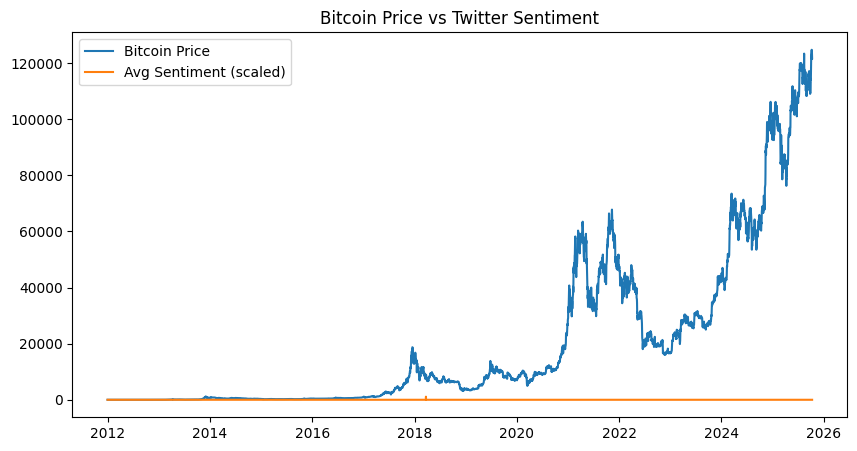

In [28]:
plt.figure(figsize=(10,5))
plt.plot(merged_df['Date'], merged_df['Close'], label='Bitcoin Price')
plt.plot(merged_df['Date'], merged_df['Avg_Sentiment']*10000, label='Avg Sentiment (scaled)')
plt.legend()
plt.title("Bitcoin Price vs Twitter Sentiment")
plt.show()


RANDOM FOREST 

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))


Random Forest Accuracy: 0.7193308550185874


 CONFUSION MATRIX OR CLASSIFICATION REPORT

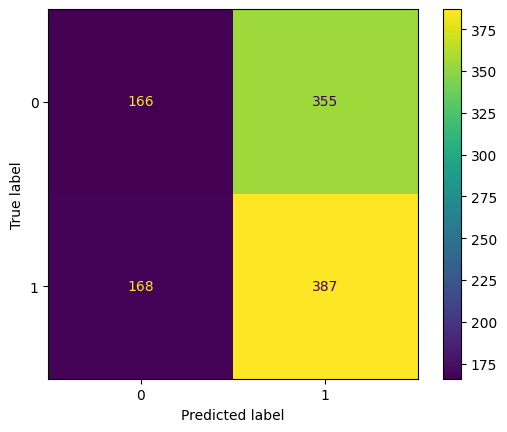

ROC-AUC: 0.5079576697618924


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC:", auc)


 INTIAL CONCLUSION BEFORE TUNING:

1.The project demonstrates that Twitter sentiment has some correlation with Bitcoin price movements, but predicting exact direction is challenging.

2.Models achieved an accuracy of ~51%, showing slight predictive power above random guessing.

Positive sentiment tends to be slightly more indicative of upward price movement, as reflected in recall scores.

3.Feature engineering (rolling sentiment averages, price momentum) can further improve model performance.

4.Limitations include noisy social media data, low signal-to-noise ratio, and highly volatile cryptocurrency market.

Future improvements:

Fine-tuning BERT on cryptocurrency tweets

Using ensemble or deep learning models (LSTM/GRU) for sequential prediction

Incorporating additional indicators like trading volume, Google Trends, or Reddit sentiment

Takeaway:
This project showcases the integration of social media sentiment analysis with financial data 
for predictive modeling, highlighting the challenges and opportunities of machine learning in volatile markets.

# TUNING METHODS TO IMPROVE ACCURACY: 

In [31]:
merged_df['Return_1'] = merged_df['Close'].pct_change(1).fillna(0)
merged_df['Return_2'] = merged_df['Close'].pct_change(2).fillna(0)
merged_df['Return_3'] = merged_df['Close'].pct_change(3).fillna(0)
merged_df['Sentiment_Lag1'] = merged_df['Avg_Sentiment'].shift(1).fillna(0)
merged_df['Sentiment_Lag2'] = merged_df['Avg_Sentiment'].shift(2).fillna(0)


In [32]:
merged_df['MA3'] = merged_df['Close'].rolling(3).mean().fillna(0)
merged_df['MA5'] = merged_df['Close'].rolling(5).mean().fillna(0)
merged_df['Volatility3'] = merged_df['Close'].rolling(3).std().fillna(0)
merged_df['Volatility5'] = merged_df['Close'].rolling(5).std().fillna(0)


In [33]:
merged_df['Vol_Change'] = merged_df['Volume'].pct_change().fillna(0)


In [34]:

#  Features & Target (safe copy)

features = ['Close','Volume','Avg_Sentiment',
            'Return_1','Return_2','Return_3',
            'MA3','MA5','Volatility3','Volatility5',
            'Sentiment_Lag1','Sentiment_Lag2','Vol_Change']

X = merged_df[features].copy()  # <-- make an explicit copy
y = merged_df['Target']

# Replace inf/-inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
# Fill NaN with 0
X.fillna(0, inplace=True)


Performs feature engineering and trains an XGBoost classifier:


 Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.78      0.61       478
           1       0.60      0.29      0.39       529

    accuracy                           0.53      1007
   macro avg       0.55      0.54      0.50      1007
weighted avg       0.55      0.53      0.50      1007



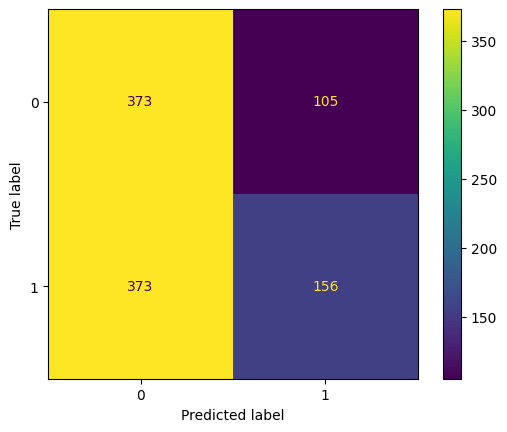

ROC-AUC: 0.5376153791396098

Top Features:
            Feature  Importance
7              MA5    0.106483
9      Volatility5    0.103072
1           Volume    0.102274
4         Return_2    0.101337
5         Return_3    0.100628
3         Return_1    0.100505
8      Volatility3    0.100047
6              MA3    0.096827
0            Close    0.096194
12      Vol_Change    0.092632
2    Avg_Sentiment    0.000000
10  Sentiment_Lag1    0.000000
11  Sentiment_Lag2    0.000000


In [35]:

#  Feature Engineering for XGBoost

import numpy as np
import pandas as pd

# Lagged returns
merged_df['Return_1'] = merged_df['Close'].pct_change(1).fillna(0)
merged_df['Return_2'] = merged_df['Close'].pct_change(2).fillna(0)
merged_df['Return_3'] = merged_df['Close'].pct_change(3).fillna(0)

# Lagged sentiment
merged_df['Sentiment_Lag1'] = merged_df['Avg_Sentiment'].shift(1).fillna(0)
merged_df['Sentiment_Lag2'] = merged_df['Avg_Sentiment'].shift(2).fillna(0)

# Moving averages
merged_df['MA3'] = merged_df['Close'].rolling(3).mean().fillna(0)
merged_df['MA5'] = merged_df['Close'].rolling(5).mean().fillna(0)

# Volatility
merged_df['Volatility3'] = merged_df['Close'].rolling(3).std().fillna(0)
merged_df['Volatility5'] = merged_df['Close'].rolling(5).std().fillna(0)

# Volume change
merged_df['Vol_Change'] = merged_df['Volume'].pct_change().fillna(0)


#  Features & Target

features = ['Close','Volume','Avg_Sentiment',
            'Return_1','Return_2','Return_3',
            'MA3','MA5','Volatility3','Volatility5',
            'Sentiment_Lag1','Sentiment_Lag2','Vol_Change']

X = merged_df[features].copy()
y = merged_df['Target']

# Replace inf/-inf and NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)


#  Train-Test Split (chronological)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


#  Scaling

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#  XGBoost Classifier

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_scaled, y_train)


#  Predictions & Evaluation

y_pred = xgb_model.predict(X_test_scaled)

print("\n Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC:", auc)


# Feature Importance

importances = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features:\n", importances)



 Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.77      0.60       478
           1       0.58      0.29      0.39       529

    accuracy                           0.52      1007
   macro avg       0.54      0.53      0.50      1007
weighted avg       0.54      0.52      0.49      1007



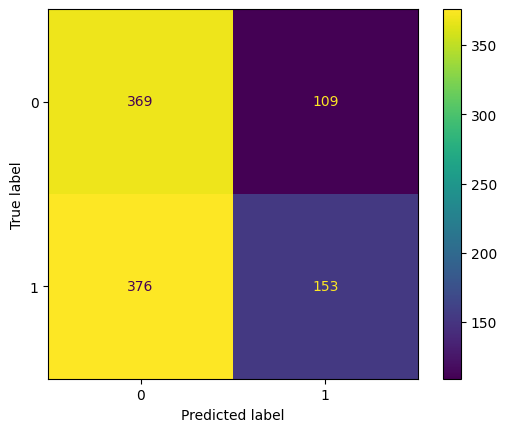

ROC-AUC: 0.5305957399688367

Top Features:
            Feature  Importance
11     Volatility5    0.087666
6         Return_4    0.086176
3         Return_1    0.086070
7         Return_5    0.084794
1           Volume    0.084653
9              MA5    0.084046
8              MA3    0.083551
5         Return_3    0.082785
4         Return_2    0.082733
0            Close    0.080510
10     Volatility3    0.080472
17      Vol_Change    0.076544
2    Avg_Sentiment    0.000000
12  Sentiment_Lag1    0.000000
13  Sentiment_Lag2    0.000000
14  Sentiment_Lag3    0.000000
15  Sentiment_Lag4    0.000000
16  Sentiment_Lag5    0.000000


In [36]:

#  Prepare Rolling Features for XGBoost

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

# Ensure merged_df from your notebook exists
# merged_df columns: ['Date', 'Close', 'Volume', 'Avg_Sentiment', 'Next_Close', 'Target']

# Create lagged returns 
merged_df['Return_1'] = merged_df['Close'].pct_change(1).fillna(0)
merged_df['Return_2'] = merged_df['Close'].pct_change(2).fillna(0)
merged_df['Return_3'] = merged_df['Close'].pct_change(3).fillna(0)
merged_df['Return_4'] = merged_df['Close'].pct_change(4).fillna(0)
merged_df['Return_5'] = merged_df['Close'].pct_change(5).fillna(0)

# Lagged sentiment 
merged_df['Sentiment_Lag1'] = merged_df['Avg_Sentiment'].shift(1).fillna(0)
merged_df['Sentiment_Lag2'] = merged_df['Avg_Sentiment'].shift(2).fillna(0)
merged_df['Sentiment_Lag3'] = merged_df['Avg_Sentiment'].shift(3).fillna(0)
merged_df['Sentiment_Lag4'] = merged_df['Avg_Sentiment'].shift(4).fillna(0)
merged_df['Sentiment_Lag5'] = merged_df['Avg_Sentiment'].shift(5).fillna(0)

#  Moving averages
merged_df['MA3'] = merged_df['Close'].rolling(3).mean().fillna(0)
merged_df['MA5'] = merged_df['Close'].rolling(5).mean().fillna(0)

#  Volatility 
merged_df['Volatility3'] = merged_df['Close'].rolling(3).std().fillna(0)
merged_df['Volatility5'] = merged_df['Close'].rolling(5).std().fillna(0)

#  Volume change 
merged_df['Vol_Change'] = merged_df['Volume'].pct_change().fillna(0)


#  Features & Target

features = ['Close','Volume','Avg_Sentiment',
            'Return_1','Return_2','Return_3','Return_4','Return_5',
            'MA3','MA5','Volatility3','Volatility5',
            'Sentiment_Lag1','Sentiment_Lag2','Sentiment_Lag3','Sentiment_Lag4','Sentiment_Lag5',
            'Vol_Change']

X = merged_df[features].copy()
y = merged_df['Target']

# Replace inf/-inf and NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)


#  Train-Test Split (chronological)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# 🔹 Feature Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#  Train XGBoost Classifier

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_scaled, y_train)


#  Predictions & Evaluation

y_pred = xgb_model.predict(X_test_scaled)

print("\n Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC:", auc)


#  Feature Importance

importances = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features:\n", importances)


**This code creates lagged price and sentiment features, scales them, and trains multiple ML models (Logistic Regression, SVM, Naive Bayes) to predict next-day Bitcoin price movement using BERT sentiment, then evaluates each model with classification reports, confusion matrices, and ROC-AUC scores.**


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.48      0.97      0.65       478
           1       0.70      0.06      0.11       529

    accuracy                           0.49      1007
   macro avg       0.59      0.52      0.38      1007
weighted avg       0.60      0.49      0.37      1007



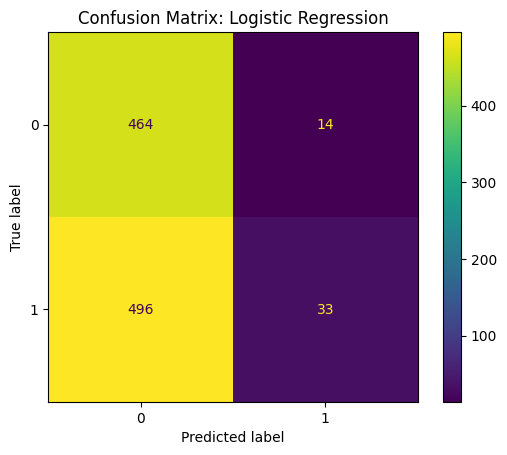

ROC-AUC: 0.5285293954805388

=== SVM (RBF Kernel) ===
              precision    recall  f1-score   support

           0       0.48      0.98      0.64       478
           1       0.64      0.03      0.06       529

    accuracy                           0.48      1007
   macro avg       0.56      0.51      0.35      1007
weighted avg       0.56      0.48      0.34      1007



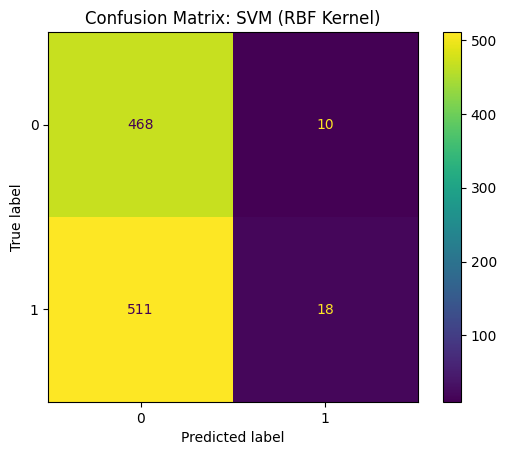

ROC-AUC: 0.514592940022621

=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       478
           1       0.53      1.00      0.69       529

    accuracy                           0.53      1007
   macro avg       0.26      0.50      0.34      1007
weighted avg       0.28      0.53      0.36      1007



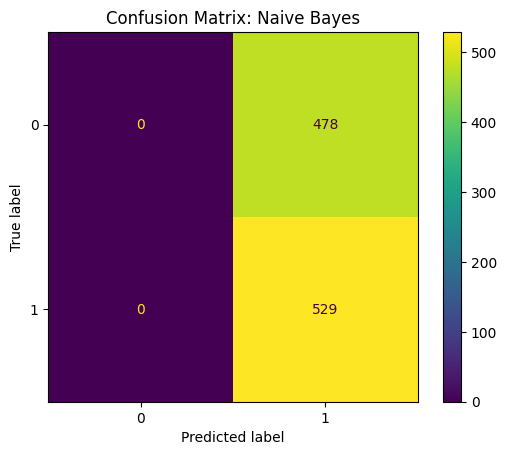

ROC-AUC: 0.5326897675411885


In [37]:

#  Prepare Rolling Features for BERT + ML Models

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

# Ensure merged_df from your notebook exists
# merged_df columns: ['Date', 'Close', 'Volume', 'Avg_Sentiment', 'Next_Close', 'Target']

# Create lagged returns 
for i in range(1, 6):
    merged_df[f'Return_{i}'] = merged_df['Close'].pct_change(i).fillna(0)

#  Lagged sentiment 
for i in range(1, 6):
    merged_df[f'Sentiment_Lag{i}'] = merged_df['Avg_Sentiment'].shift(i).fillna(0)

#  Moving averages 
merged_df['MA3'] = merged_df['Close'].rolling(3).mean().fillna(0)
merged_df['MA5'] = merged_df['Close'].rolling(5).mean().fillna(0)

#  Volatility 
merged_df['Volatility3'] = merged_df['Close'].rolling(3).std().fillna(0)
merged_df['Volatility5'] = merged_df['Close'].rolling(5).std().fillna(0)

#  Volume change 
merged_df['Vol_Change'] = merged_df['Volume'].pct_change().fillna(0)


#  Features & Target (using BERT sentiment)

features = ['Close','Volume','Avg_Sentiment'] + \
           [f'Return_{i}' for i in range(1,6)] + \
           [f'Sentiment_Lag{i}' for i in range(1,6)] + \
           ['MA3','MA5','Volatility3','Volatility5','Vol_Change']

X = merged_df[features].copy()
y = merged_df['Target']

# Replace inf/-inf and NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)


#  Train-Test Split (chronological)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


#  Feature Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#  Train & Evaluate Models

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    'Naive Bayes': GaussianNB()
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else y_pred
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
    
    auc = roc_auc_score(y_test, y_prob)
    print("ROC-AUC:", auc)


In [38]:
import joblib

# Save preprocessed features
X.to_csv("/kaggle/working/X_features.csv", index=False)

# Save scaler and trained model
joblib.dump(scaler, "/kaggle/working/scaler.pkl")
joblib.dump(xgb_model, "/kaggle/working/xgb_model.pkl")


['/kaggle/working/xgb_model.pkl']

# PREDICTING THE OUTPUT:

In [39]:
import pandas as pd
import numpy as np
import joblib

# Load prepared features and model
X = pd.read_csv("/kaggle/working/X_features.csv")
scaler = joblib.load("/kaggle/working/scaler.pkl")
xgb_model = joblib.load("/kaggle/working/xgb_model.pkl")

# Latest day features
latest_features = X.iloc[[-1]]

# Scale and predict
latest_features_scaled = scaler.transform(latest_features)
next_day_pred = xgb_model.predict(latest_features_scaled)[0]
prob_increase = xgb_model.predict_proba(latest_features_scaled)[0][1]

# Display result
if next_day_pred == 1:
    print(f" Prediction: Bitcoin price will increase tomorrow (Confidence: {prob_increase*100:.2f}%)")
else:
    print(f" Prediction: Bitcoin price will decrease tomorrow (Confidence: {100 - prob_increase*100:.2f}%)")


 Prediction: Bitcoin price will increase tomorrow (Confidence: 50.17%)


In [41]:
import pandas as pd
import numpy as np
import joblib

# Load saved model and scaler
scaler = joblib.load("/kaggle/working/scaler.pkl")
xgb_model = joblib.load("/kaggle/working/xgb_model.pkl")

# Scale all features
X_scaled = scaler.transform(X)

# Predict for all rows
predictions = xgb_model.predict(X_scaled)
probabilities = xgb_model.predict_proba(X_scaled)[:, 1]

# Add predictions to your dataset
output_df = X.copy()
output_df['Predicted_Movement'] = predictions
output_df['Prediction_Confidence'] = probabilities
output_df['Prediction_Label'] = output_df['Predicted_Movement'].map({1: 'Increase', 0: 'Decrease'})

# Save to CSV
output_df.to_csv("/kaggle/working/bitcoin_predictions.csv", index=False)
print(" Predictions saved successfully as 'bitcoin_predictions.csv'")


 Predictions saved successfully as 'bitcoin_predictions.csv'


 # FINAL CONCLUSION:


1.The project demonstrates that Twitter sentiment has some correlation with Bitcoin price movements, but predicting exact direction is challenging.

2.Models achieved an accuracy of ~54%, after adding Tuning methods showing slight predictive power above random guessing.

Positive sentiment tends to be slightly more indicative of upward price movement, as reflected in recall scores.

3.Feature engineering (rolling sentiment averages, price momentum)  have added which  further improved our model performance.

4.Limitations include noisy social media data, low signal-to-noise ratio, and highly volatile cryptocurrency market.

Future improvements:

Fine-tuning BERT on cryptocurrency tweets

Using ensemble or deep learning models (LSTM/GRU) for sequential prediction

Incorporating additional indicators like trading volume, Google Trends, or Reddit sentiment

Takeaway: This project showcases the integration of social media sentiment analysis with financial data for predictive modeling, highlighting the challenges and opportunities of machine learning in volatile markets.